In [1]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense

In [2]:
df = pd.read_pickle('C:\\Users\\josek\\Documents\\gitMCC\\MCC-2023-1AD\\Affective_FER\\affective_dataset_v2_48x48.pkl')

In [3]:
df.head()

,image,face_closeup,face_landmarks,label
0,"[[29, 24, 29, 11, 15, 22, 26, 11, 7, 17, 29, 2...","[[46, 49, 55, 36, 72, 109, 133, 134, 117, 102,...","[[16, 18], [15, 23], [14, 27], [15, 32], [16, ...",angry
1,"[[155, 138, 98, 112, 94, 97, 111, 107, 101, 84...","[[84, 83, 90, 86, 117, 141, 129, 115, 164, 191...","[[5, 22], [8, 26], [11, 29], [15, 33], [19, 35...",angry
2,"[[211, 215, 220, 221, 219, 216, 213, 210, 207,...","[[220, 221, 219, 216, 213, 210, 207, 205, 202,...","[[4, 18], [5, 23], [6, 28], [8, 33], [11, 38],...",angry
3,"[[36, 37, 34, 40, 54, 65, 67, 57, 48, 50, 49, ...","[[20, 59, 82, 72, 69, 66, 87, 164, 181, 177, 1...","[[7, 18], [7, 23], [9, 28], [10, 33], [12, 37]...",angry
4,"[[34, 31, 32, 31, 25, 30, 40, 41, 40, 37, 57, ...","[[57, 76, 92, 107, 118, 121, 125, 128, 129, 13...","[[4, 26], [5, 31], [6, 35], [8, 39], [10, 43],...",angry


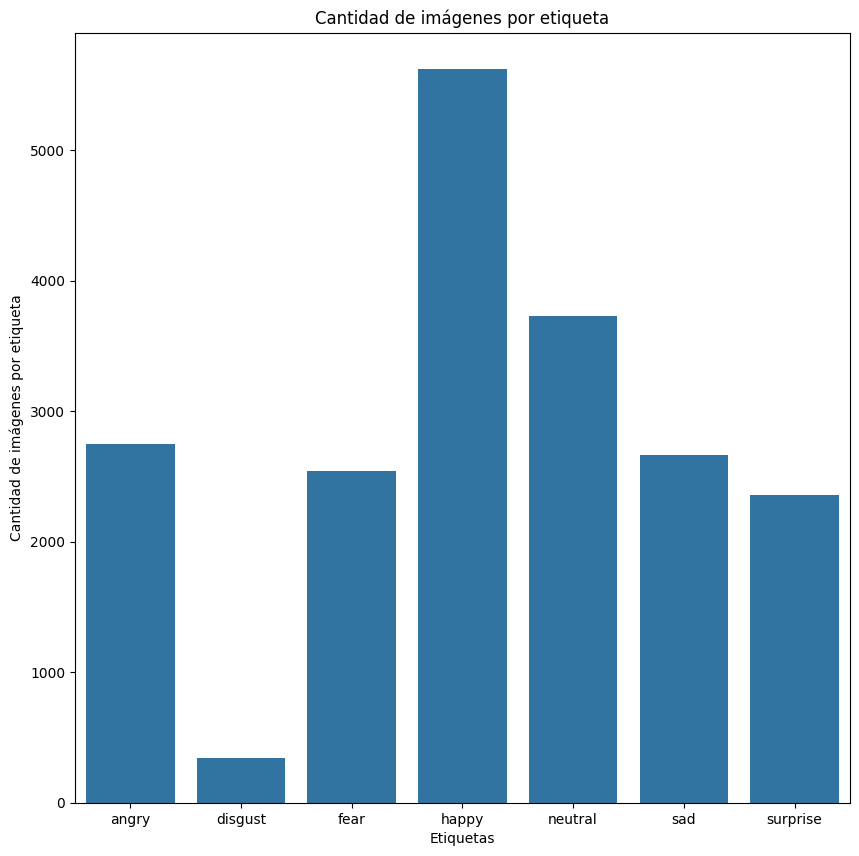

In [6]:
import seaborn as sns
plt.figure(figsize=(10, 10))
sns.countplot(x='label', data=df)
plt.xlabel('Etiquetas')
plt.ylabel('Cantidad de imágenes por etiqueta')
plt.title('Cantidad de imágenes por etiqueta')
plt.show()

In [7]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['label'])

In [8]:
x = np.array(df['face_landmarks'].tolist())

In [9]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3,stratify=y, random_state=42)

In [10]:
from keras.layers import Input, Flatten, Dense, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.regularizers import l2

# Definir la entrada del modelo
inputs = Input(shape=(144, 2))

# Aplanar los datos de entrada
flatten = Flatten()(inputs)

# Capas densas

#dense8 = Dense(200, activation='relu')(flatten)
#dense9 = Dense(180, activation='relu')(dense8)
#dense10 = Dense(64, activation='relu')(dense9)
dense8 = Dense(600, activation='relu')(flatten)
dense9 = Dense(300, activation='relu')(dense8)
dense10 = Dense(150, activation='relu')(dense9)
dense11 = Dense(64, activation='relu')(dense10)
dense12 = Dense(32, activation='relu')(dense11)


# Capa de salida
outputs = Dense(len(label_encoder.classes_), activation='softmax')(dense12)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [10]:
from keras.layers import Input, Flatten, Dense, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.regularizers import l2

# Entrada del modelo
inputs = Input(shape=(144, 2))

# Aplanar los datos de entrada
flatten = Flatten()(inputs)

# Capas ocultas
dense1 = Dense(600, activation='relu')(flatten)
dense2 = Dense(480, activation='relu')(dense1)
dense3 = Dense(64, activation='relu')(dense2)


# Capa de salida
outputs = Dense(len(label_encoder.classes_), activation='softmax')(dense3)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [11]:
# Callback Matriz de Confusion
class ConfusionMatrixCallback(tf.keras.callbacks.Callback):
    def __init__(self, log_dir, x_val, y_val):
        super().__init__()
        self.log_dir = log_dir
        self.x_val = x_val
        self.y_val = y_val
        self.file_writer_cm = tf.summary.create_file_writer(log_dir + '/cm')

    def on_epoch_end(self, epoch, logs=None):
        val_pred = np.argmax(self.model.predict(self.x_val), axis=1)
        cm = confusion_matrix(self.y_val, val_pred)
        labels_class = ['angry' ,'disgust' ,'fear' ,'happy', 'neutral' ,'sad' ,'surprise']
        
        figure = plt.figure(figsize=(8, 8))
        sns.heatmap(cm, annot=True, fmt="d", cmap=plt.cm.Blues, xticklabels=labels_class, yticklabels=labels_class)
        plt.title("Confusion Matrix")
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        
        cm_image = self.plot_to_image(figure)
        
        with self.file_writer_cm.as_default():
            tf.summary.image("Confusion Matrix", cm_image, step=epoch)

    def plot_to_image(self, figure):
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        plt.close(figure)
        buf.seek(0)
        image = tf.image.decode_png(buf.getvalue(), channels=4)
        image = tf.expand_dims(image, 0)
        return image

In [12]:
# Configurar TensorBoard
import datetime
from tensorflow.keras.callbacks import TensorBoard
log_dir = "Affective_FER/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Configurar el callback de la matriz de confusión
confusion_matrix_callback = ConfusionMatrixCallback(log_dir, X_test, y_test)

In [13]:
model.fit(X_train, y_train, epochs=800, batch_size=32, callbacks=[tensorboard_callback, confusion_matrix_callback])

Epoch 1/800


ValueError: in user code:

    File "c:\Users\josek\.conda\envs\tf\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\josek\.conda\envs\tf\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\josek\.conda\envs\tf\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\josek\.conda\envs\tf\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\josek\.conda\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\josek\.conda\envs\tf\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 144, 2), found shape=(None, 72, 2)


In [17]:
# Evaluar el modelo
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

241/241 [==============================] - 1s 6ms/step - loss: 1.3936 - accuracy: 0.4788
Loss: 1.3936376571655273, Accuracy: 0.4788476526737213


In [14]:
model.save('1MLPFER.h5')